In [1]:
import sys
import requests
import json
import matplotlib.pyplot as plt
from statistics import mean
from statistics import pstdev
from time import sleep, time

def parse_names(raw_input):
    return [name.strip(' ').replace(' ', '_').lower() for name in raw_input.split(',')]

def format_name(driver_id):
    return driver_id.replace('_', ' ').title()

def filter_none(iterable):
    return list(filter(lambda i: i is not None, iterable))

def none_resilient_mean(iterable):
    iterable = filter_none(iterable)
    if iterable == []:
        return None
    else:
        return mean(iterable)

def none_resilient_std_dev(iterable):
    iterable = filter_none(iterable)
    if iterable == []:
        return None
    else:
        return pstdev(iterable)
    
def wait_for_time(start, delta):
    while time() - start < delta:
        pass
    

# Select Race

In [2]:
year = input('Select Year (leave blank for latest):\n')
if year == '':
    year = 'current'
    print('  Latest')

Select Year (leave blank for latest):
2011


In [3]:
race = input('Select Round (leave blank for latest):\n')
if race == '':
    race = 'last'
    print('  Latest')

Select Round (leave blank for latest):
7


# Options

In [4]:
exclude_driver_anomolies = input('Exclude Driver Anomolies? (E.g. Pitstop laps): ').lower() == 'yes'
exclude_race_anomolies = input('Exclude Race Anomolies? (E.g. Saftey car laps): ').lower() == 'yes'

Exclude Driver Anomolies? (E.g. Pitstop laps): 
Exclude Race Anomolies? (E.g. Saftey car laps): 


# Race Result

In [5]:
response = json.loads(requests.get(f'http://ergast.com/api/f1/{year}/{race}/results.json').content)
race_data = response['MRData']['RaceTable']['Races'][0]
result = race_data['Results']

print(f'''
{race_data['raceName']}
{'=' * len(race_data['raceName'])}
Season: {race_data['season']}
Round: {race_data['round']}
Circuit: {race_data['Circuit']['circuitName']}
''')

for i in range(len(result)):
    print(f"{str(i + 1).rjust(3) if result[i]['status'] == 'Finished' else 'DNF'}: {result[i]['Driver']['givenName']} {result[i]['Driver']['familyName']} - {result[i]['Constructor']['name']}")




Canadian Grand Prix
Season: 2011
Round: 7
Circuit: Circuit Gilles Villeneuve

  1: Jenson Button - McLaren
  2: Sebastian Vettel - Red Bull
  3: Mark Webber - Red Bull
  4: Michael Schumacher - Mercedes
  5: Vitaly Petrov - Renault
  6: Felipe Massa - Ferrari
  7: Kamui Kobayashi - Sauber
  8: Jaime Alguersuari - Toro Rosso
  9: Rubens Barrichello - Williams
 10: Sébastien Buemi - Toro Rosso
 11: Nico Rosberg - Mercedes
 12: Pedro de la Rosa - Sauber
DNF: Vitantonio Liuzzi - HRT
DNF: Narain Karthikeyan - HRT
DNF: Jérôme d'Ambrosio - Virgin
DNF: Timo Glock - Virgin
DNF: Jarno Trulli - Lotus
DNF: Paul di Resta - Force India
DNF: Pastor Maldonado - Williams
DNF: Nick Heidfeld - Renault
DNF: Adrian Sutil - Force India
DNF: Fernando Alonso - Ferrari
DNF: Heikki Kovalainen - Lotus
DNF: Lewis Hamilton - McLaren


# Load Lap Times

In [6]:
laps = int(result[0]['laps'])
drivers = [i['Driver']['driverId'] for i in result]
lap_times = {driver : [] for driver in drivers}

last_call = 0
for i in range(1, laps + 1):
    sys.stdout.write(f'\rFetching data for lap {i} of {laps}...')
    sys.stdout.flush
    wait_for_time(last_call, 0.3)
    response = json.loads(requests.get(f'http://ergast.com/api/f1/{year}/{race}/laps/{i}.json').content)
    last_call = time()
    lap_timings = response['MRData']['RaceTable']['Races'][0]['Laps'][0]['Timings']
    for driver_time in lap_timings:
        driver_id = driver_time['driverId']
        str_time = driver_time['time']
        int_secs = int(str_time.split(':')[0]) * 60 + float(str_time.split(':')[1])
        lap_times[driver_id].append(int_secs)

for i in lap_times.keys():
    while len(lap_times[i]) < laps:
        lap_times[i].append(None)

if exclude_driver_anomolies:
    for driver, times in lap_times.items():
        times = filter_none(times)
        if times == []:
            continue
    
        avg = mean(times)
        std_deviation = pstdev(times)
        for i, time in enumerate(times):
            if abs(time - avg) > std_deviation * 0.5:
                lap_times[driver][i] = None

lap_times_by_lap = list(zip(*[lap_times[driver] for driver in drivers]))
if exclude_race_anomolies:
    avg_per_lap_all_drivers = [none_resilient_mean(times) for times in lap_times_by_lap]
    avg_all_laps_all_drivers = mean(filter_none(avg_per_lap_all_drivers))
    std_deviation = pstdev(filter_none(avg_per_lap_all_drivers))
    for lap, avg_time in enumerate(avg_per_lap_all_drivers):
        if avg_time is not None:
            if abs(avg_all_laps_all_drivers - avg_time) > std_deviation * 0.5:
                lap_times_by_lap[lap] = [None] * len(drivers)

print('\nCompleted!')

Fetching data for lap 70 of 70...
Completed!


# Plot Lap Times

Select drivers to compare from the following:
e.g: Hamilton, Max Verstappen

 - Button
 - Vettel
 - Webber
 - Michael Schumacher
 - Petrov
 - Massa
 - Kobayashi
 - Alguersuari
 - Barrichello
 - Buemi
 - Rosberg
 - Rosa
 - Liuzzi
 - Karthikeyan
 - Ambrosio
 - Glock
 - Trulli
 - Resta
 - Maldonado
 - Heidfeld
 - Sutil
 - Alonso
 - Kovalainen
 - Hamilton

Compare:
Button, Vettel, webber, michael schumacher


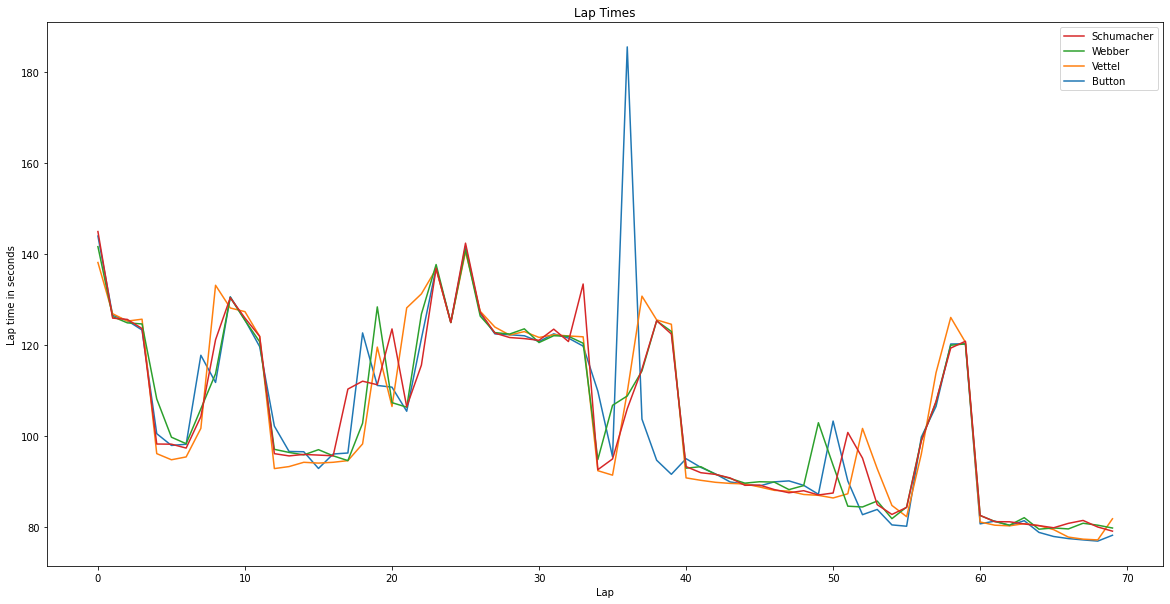

In [7]:
print('Select drivers to compare from the following:')
print('e.g: Hamilton, Max Verstappen\n')
for i in drivers:
    print(f" - {format_name(i)}")
    
COMPARE = parse_names(input('\nCompare:\n'))

fig1 = plt.figure(figsize=(20,10))
plt_lap_times = fig1.add_subplot()
plt_lap_times.set_title('Lap Times')
plt_lap_times.set_xlabel('Lap')
plt_lap_times.set_ylabel('Lap time in seconds')

for i in COMPARE:
    plt_lap_times.plot(lap_times[i], label=format_name(i).split(' ')[-1])

handles, labels = plt_lap_times.get_legend_handles_labels()
plt_lap_times.legend(handles[::-1], labels[::-1])


# Delta to Average Lap Time

Select drivers to compare from the following:
 - Button
 - Vettel
 - Webber
 - Michael Schumacher
 - Petrov
 - Massa
 - Kobayashi
 - Alguersuari
 - Barrichello
 - Buemi
 - Rosberg
 - Rosa
 - Liuzzi
 - Karthikeyan
 - Ambrosio
 - Glock
 - Trulli
 - Resta
 - Maldonado
 - Heidfeld
 - Sutil
 - Alonso
 - Kovalainen
 - Hamilton

Compare:
Button

Against average of:
(leave blank for all):
Vettel, webber, michael schumacher


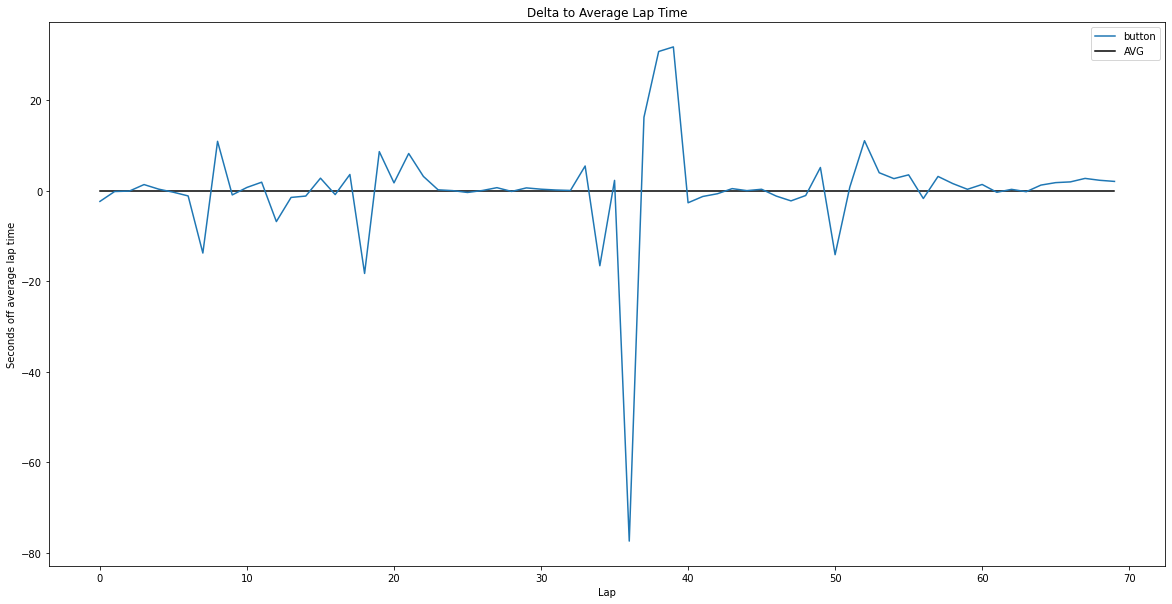

In [8]:
print('Select drivers to compare from the following:')
for i in drivers:
    print(f" - {format_name(i)}")

COMPARE = parse_names(input('\nCompare:\n'))
COMPARE_AGAINST = parse_names(input('\nAgainst average of:\n(leave blank for all):\n'))

if COMPARE_AGAINST == ['']:
    COMPARE_AGAINST = drivers
    
lap_times_by_lap = []
for lap in range(laps):
    lap_times_by_lap.append([])
    for driver in COMPARE_AGAINST:
        driver_lap_time = lap_times[driver][lap]
        if driver_lap_time is not None:
            lap_times_by_lap[lap].append(driver_lap_time)

avg_laps = [none_resilient_mean(times) for times in lap_times_by_lap]

fig2 = plt.figure(figsize=(20,10))
plt_delta_to_average = fig2.add_subplot()
plt_delta_to_average.set_title('Delta to Average Lap Time')
plt_delta_to_average.set_xlabel('Lap')
plt_delta_to_average.set_ylabel('Seconds off average lap time')

plt_delta_to_average.plot([0] * laps, label='AVG', color='black')

for driver in COMPARE:
    data = [(avg_laps[i] - driver_time) if driver_time is not None else None for i, driver_time in enumerate(lap_times[driver])]
    plt_delta_to_average.plot(data, label=driver)

handles, labels = plt_delta_to_average.get_legend_handles_labels()
plt_delta_to_average.legend(handles[::-1], labels[::-1])

# Delta to Driver Lap Time

In [ ]:
print('Select drivers to compare from the following:')
for i in drivers:
    print(f" - {format_name(i)}")

COMPARE = parse_names(input('\nCompare:\n'))
COMPARE_AGAINST = parse_names(input('\nAgainst (select one driver):\n'))[0]
    
baseline_lap_times = lap_times[COMPARE_AGAINST]

fig3 = plt.figure(figsize=(20,10))
plt_delta_to_baseline = fig3.add_subplot()
plt_delta_to_baseline.set_title(f"Delta to {COMPARE_AGAINST.replace('_', ' ').title()}'s Lap Time")
plt_delta_to_baseline.set_xlabel('Lap')
plt_delta_to_baseline.set_ylabel(f"Seconds off {COMPARE_AGAINST.replace('_', ' ').title()}")

plt_delta_to_baseline.plot([0] * len(list(filter(lambda time: time is not None, lap_times[COMPARE_AGAINST]))), color="black")

for driver in COMPARE:
    data = [(baseline_lap_times[i] - driver_time) if (driver_time is not None and baseline_lap_times[i] is not None) else None for i, driver_time in enumerate(lap_times[driver])]
    plt_delta_to_baseline.plot(data, label=driver.replace('_', ' ').title())

handles, labels = plt_delta_to_baseline.get_legend_handles_labels()
plt_delta_to_baseline.legend(handles[::-1], labels[::-1])

Select drivers to compare from the following:
 - Button
 - Vettel
 - Webber
 - Michael Schumacher
 - Petrov
 - Massa
 - Kobayashi
 - Alguersuari
 - Barrichello
 - Buemi
 - Rosberg
 - Rosa
 - Liuzzi
 - Karthikeyan
 - Ambrosio
 - Glock
 - Trulli
 - Resta
 - Maldonado
 - Heidfeld
 - Sutil
 - Alonso
 - Kovalainen
 - Hamilton


# Future ideas
- Position plot
  - Plots the place of each driver over the race
  - Select drivers to emphasise (makes other drivers' lines partiallty transparent)
- More reusable code
  - Function to plot make plotting a chart easier maybe?
- Better data structure to store lap times
  - Probably best to have it in an actual object.
  - Has get time method/exclude time methods that take array of drivers, array of laps.
- Exclude anomolies
  - Exclude anomolus laps (Driver) - Cleans up anomolies that affected one driver. Pit stops for example.
  - Exclude anomolus laps (Grid) - Cleans up pit stops that affected the whole grid. Saftey cars for example.